In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Load dataset with encoding handling
df = pd.read_csv("IMDb Movies India.csv", encoding='ISO-8859-1')

# Drop irrelevant columns if necessary
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])


In [6]:
# Handle missing values
numerical_cols = ['Year', 'Duration', 'Votes']
categorical_cols = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
target_col = 'Rating'

# Ensure numerical columns are correctly formatted
def convert_to_numeric(value):
    try:
        return pd.to_numeric(value, errors='coerce')
    except:
        return np.nan

In [8]:
df[numerical_cols] = df[numerical_cols].map(convert_to_numeric)
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
df[categorical_cols] = df[categorical_cols].fillna("Unknown")

# Process 'Votes' column
def clean_votes(value):
    if isinstance(value, str):
        value = value.replace("$", "").replace(",", "").strip()
        if "M" in value:
            return float(value.replace("M", "")) * 1_000_000
        try:
            return float(value)
        except ValueError:
            return np.nan
    return value

In [10]:
df["Votes"] = df["Votes"].apply(clean_votes)
df["Votes"] = df["Votes"].fillna(df["Votes"].median())

# Process 'Genre' column with One-Hot Encoding
df["Genre"] = df["Genre"].str.split(", ")
genres_exploded = df.explode("Genre").reset_index(drop=True)
genre_dummies = pd.get_dummies(genres_exploded["Genre"], prefix="Genre")
df = df.join(genre_dummies.groupby(genres_exploded.index).sum())

# Apply frequency encoding to categorical variables
for col in ["Director", "Actor 1", "Actor 2", "Actor 3"]:
    df[col] = df[col].astype(str)
    freq_encoding = df[col].value_counts().to_dict()
    df[col] = df[col].map(freq_encoding)

In [12]:
# Define features and target variable
features = numerical_cols + list(genre_dummies.columns) + ["Director", "Actor 1", "Actor 2", "Actor 3"]
df = df.dropna(subset=[target_col])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target_col], test_size=0.2, random_state=42)

# Train RandomForest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RandomForest RMSE: 1.31, R²: 0.07


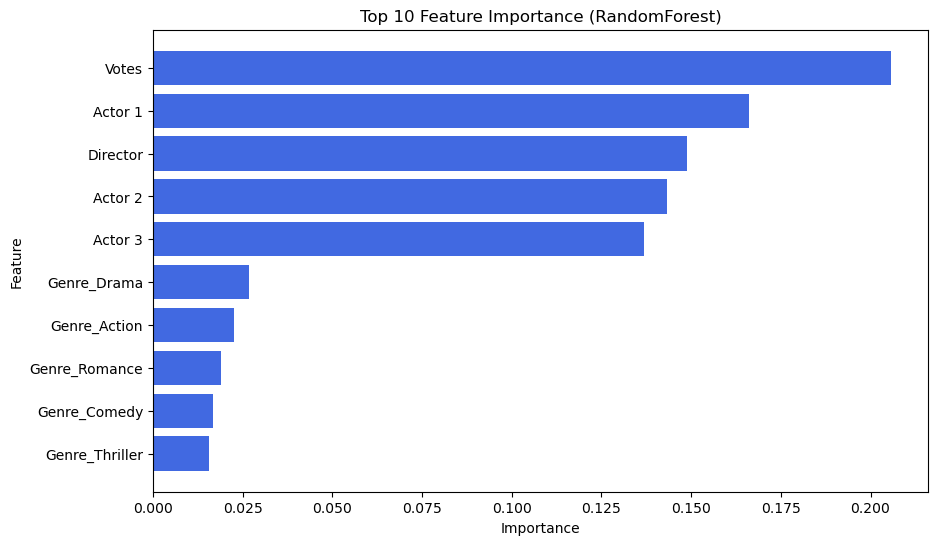

In [14]:
# Evaluate RandomForest Model
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RandomForest RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")

# Feature Importance Visualization
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx], color="royalblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance (RandomForest)")
plt.show()

In [16]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best Parameters for RandomForest:", grid_search.best_params_)


Best Parameters for RandomForest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [20]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")  # You can also use "median" or "most_frequent"
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
gb_model.fit(X_train_imputed, y_train)
y_pred_gb = gb_model.predict(X_test_imputed)

rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
r2_gb = r2_score(y_test, y_pred_gb)
print(f"GradientBoosting RMSE: {rmse_gb:.2f}, R²: {r2_gb:.2f}")


C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Year' 'Duration']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Year' 'Duration']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


GradientBoosting RMSE: 1.27, R²: 0.13


C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Handle missing values by replacing NaNs with the mean
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train and evaluate the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_imputed, y_train)
y_pred_lr = lr_model.predict(X_test_imputed)

# Calculate RMSE and R²
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr:.2f}, R²: {r2_lr:.2f}")


Linear Regression RMSE: 1.35, R²: 0.02


C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Year' 'Duration']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Year' 'Duration']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
